In [173]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd

# Keras documentation can be found on keras.io:
import tensorflow.keras
from tensorflow.keras.datasets import mnist      # NOTE: This loads the data!
# manual link to data:  http://yann.lecun.com/exdb/mnist/
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, concatenate
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split
import glob
from PIL import Image

import tensorflow as tf
#import tf.compat.v1.train.AdamOptimizer as adam
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [175]:
file = 'data_codingset_onelist_sharpness_and_contrast_64_7000.npz'
file1 = 'data_codingset_onelist_64_2000.npz'
data = np.load(file )

test_data = np.load('data_test_ice_core.npz')


In [130]:
[x.dtype for x in [train_images, val_images_, train_labels, val_labels_]]

[dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8')]

In [122]:
[x.dtype for x in [data['data'], data['labels']]]

[dtype('uint8'), dtype('float64')]

In [176]:
train_images, val_images_, train_labels, val_labels_ = train_test_split(data['data'].astype("uint8"), data['labels'].astype("uint8"), test_size=0.4, random_state=13052020)
val_images, test_images, val_labels, test_labels = train_test_split(val_images_, val_labels_, test_size=0.5, random_state=13052020)

meta_train_images, meta_rest_images, meta_train_label, meta_rest_label = train_test_split(data['metadata'].astype("float32"), data['labels'].astype("uint8"), test_size=0.4, random_state=13052020)
meta_val_images, meta_test_images, meta_val_labels, meta_test_labels = train_test_split(meta_rest_images, meta_rest_label, test_size=0.5, random_state=13052020)


In [177]:
# the data, split between train and testval sets
#(train_images, train_labels), (testval_images, testval_labels) = data.load_data()

# further split testval set into specific test and validation set
# the test set is NOT used during any part but inference
#train_images, val_images, train_labels, val_labels = train_test_split(testval_images, testval_labels, test_size=0.2, random_state=13052020)

# explicitly illustrating standardization
def standardizeimg(img, mu, sigma):
    return (img-mu)/(sigma).astype(np.float32)

# save for scaling test data
mu_train = np.mean(train_images)
sigma_train = np.std(train_images)

meta_mu = np.mean(meta_train_images)
meta_sigma = np.std(meta_train_images)

# Standardize pixel distribution to have zero mean and unit variance
train_images = standardizeimg(img=train_images, mu=mu_train, sigma=sigma_train)
val_images = standardizeimg(img=val_images, mu=np.mean(val_images), sigma=np.std(val_images))

meta_train_images = standardizeimg(img=meta_train_images, mu=meta_mu, sigma=meta_sigma)
meta_val_images = standardizeimg(img=meta_val_images, mu=np.mean(meta_val_images), sigma=np.std(meta_val_images))

# adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
img_rows, img_cols = 64, 64 # input image dimensions
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, 1)

# convert class vectors to binary class matrices - one hot encoding
num_classes = 6
train_labels = tensorflow.keras.utils.to_categorical(train_labels, num_classes)
val_labels = tensorflow.keras.utils.to_categorical(val_labels, num_classes)

# avoid using statistics intrinsic to test data to ensure unbiased estimate of real model performance
test_images = standardizeimg(img=test_images, mu=mu_train, sigma=sigma_train)
meta_test_images = standardizeimg(meta_test_images,mu = meta_mu , sigma = meta_sigma)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
test_labels = tensorflow.keras.utils.to_categorical(test_labels, num_classes)

In [178]:
Test_images = standardizeimg(img=test_data['test_img'].astype("uint8"), mu=np.mean(test_data['test_img']), sigma=np.std(test_data['test_img']))
meta_Test_images = standardizeimg(img=test_data['test_meta'].astype("float32"), mu=np.mean(test_data['test_meta']), sigma=np.std(test_data['test_meta']))
Test_images = Test_images.reshape(Test_images.shape[0], img_rows, img_cols, 1)

In [179]:
input_img = Input(shape = (img_rows, img_cols, 1))
input_meta = Input(shape = (39,))

x = Conv2D(filters=32,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu')(input_img)
x = MaxPooling2D(pool_size=2, strides=None)(x)
x = Conv2D(filters=64,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu')(x)
x = MaxPooling2D(pool_size=2, strides=None)(x)

x = Dropout(rate=0.20)(x)

x = Flatten()(x)
x = Dense(units=128, activation='relu')(x) 
x1 = Dense(128,activation = 'sigmoid')(input_meta) #New
x = concatenate([x,x1])
x = Dense(1024,activation = 'sigmoid')(x)

output = Dense(units=num_classes, activation='softmax')(x)

model = Model(inputs = [input_img ,input_meta], outputs = output)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 32, 32, 32)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 64)   18496       max_pooling2d_6[0][0]            
____________________________________________________________________________________________

In [180]:
cce = tf.keras.losses.CategoricalCrossentropy()
#print(cce(t, p))

In [181]:
def CustomCCE(target, prediction):
    M = np.ones((6,6))
    M[4,5], M[5,4] = 10,10
    M[0,3], M[3,0] = 10, 10
    M[1,5], M[5,1] = 2,2
    M[1,4], M[4,1] = 2,2
    
    M -= np.identity(6)

    #M = tf.convert_to_tensor(M, np.float64)
    tg = np.argmax(target.numpy(), axis=1)  
    pg = np.argmax(prediction.numpy(), axis=1) 

    #
    coeff = M[tg, pg]
    cce = tf.keras.losses.CategoricalCrossentropy()
    val = cce(target, prediction)
    val = val*coeff
    #print(f'Prediction: {pg} | actual: {tg} | loss: {val}')
    return val

In [182]:
model.compile(loss = CustomCCE,
              optimizer = tensorflow.keras.optimizers.Adam(), run_eagerly=True,
              metrics = [CustomCCE])

# the history object will contain a record of loss and metric values during training
callback = tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5)

history = model.fit([train_images, meta_train_images], train_labels,
                    batch_size=128,
                    epochs=10,
                    verbose=1, callbacks = [callback],
                    validation_data=([val_images, meta_val_images], val_labels))

Epoch 1/10
197/197 [==============================] - 172s 859ms/step - loss: 1.5689 - CustomCCE: 1.5689 - val_loss: 0.5177 - val_CustomCCE: 0.5177
Epoch 2/10
197/197 [==============================] - 175s 888ms/step - loss: 0.4901 - CustomCCE: 0.4901 - val_loss: 0.5341 - val_CustomCCE: 0.5341
Epoch 3/10
197/197 [==============================] - 184s 933ms/step - loss: 0.3989 - CustomCCE: 0.3989 - val_loss: 0.3699 - val_CustomCCE: 0.3699
Epoch 4/10
197/197 [==============================] - 201s 1s/step - loss: 0.3428 - CustomCCE: 0.3428 - val_loss: 0.3111 - val_CustomCCE: 0.3111
Epoch 5/10
197/197 [==============================] - 146s 739ms/step - loss: 0.2448 - CustomCCE: 0.2448 - val_loss: 0.3246 - val_CustomCCE: 0.3246
Epoch 6/10
197/197 [==============================] - 147s 747ms/step - loss: 0.2280 - CustomCCE: 0.2280 - val_loss: 0.3106 - val_CustomCCE: 0.3106
Epoch 7/10
197/197 [==============================] - 137s 695ms/step - loss: 0.1631 - CustomCCE: 0.1631 - val_loss

In [183]:
# using until now unseen data
predicted_prob = model.predict([test_images, meta_test_images])
predictions = np.argmax(predicted_prob, axis=1)

In [184]:
conf_matrix = tf.math.confusion_matrix(labels=np.argmax(test_labels, axis=1), predictions=predictions, num_classes=6)
print('Confusion Matrix: ', conf_matrix)

# Original code:
#sess = tf.compat.v1.InteractiveSession()
#conf_matrix = confusion.eval(session=sess)     # Needs update to new TF...
#sess.close()

# Accuracy score for inference
error_rate = (np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))) / np.sum(np.diag(conf_matrix))
inf_acc = 1-error_rate

Confusion Matrix:  tf.Tensor(
[[1362    6    5   51    5    0]
 [  12 1318    0    3    9    0]
 [  46    0 1323    2    0    0]
 [ 275   13    2 1116    3    9]
 [  15   23    0    5 1156  198]
 [   8   26    0   12  233 1164]], shape=(6, 6), dtype=int32)


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: callable
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font_properties: `.font_manager.FontProperties`
  fontsize or size: {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  fontweight or weight: {a numeric

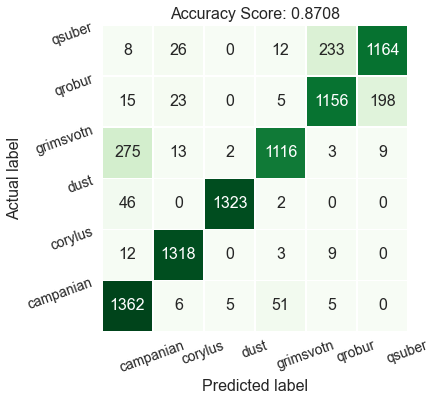

Correct: 7439/8400
Wrong: 961/8400


In [188]:
fig=plt.figure(figsize=(6,6))
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, square=True, cbar=False, cmap='Greens')
ax.invert_yaxis()
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.title('Accuracy Score: {:.4f}'.format(inf_acc), fontsize=16)

path = ["campanian","corylus","dust","grimsvotn","qrobur","qsuber"]

plt.xticks(range(len(path)),path, rotation=20)
plt.yticks(range(len(path)),path, rotation=20)
plt.setp( ax.xaxis.get_majorticklabels()) 

import matplotlib.transforms

# Create offset transform by 5 points in x direction
dx = 50/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

plt.setp( ax.yaxis.get_majorticklabels()) 

# Create offset transform by 5 points in x direction
dx = 0/72.; dy = 50/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax.yaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
plt.tight_layout()
plt.show()

print('Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix)),np.sum(conf_matrix)))
print('Wrong: {0}/{1}'.format((np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))),np.sum(conf_matrix)))
fig.savefig('subtypes_conf_matrix', dpi=75)

AttributeError: 'AxesSubplot' object has no attribute 'xticks'

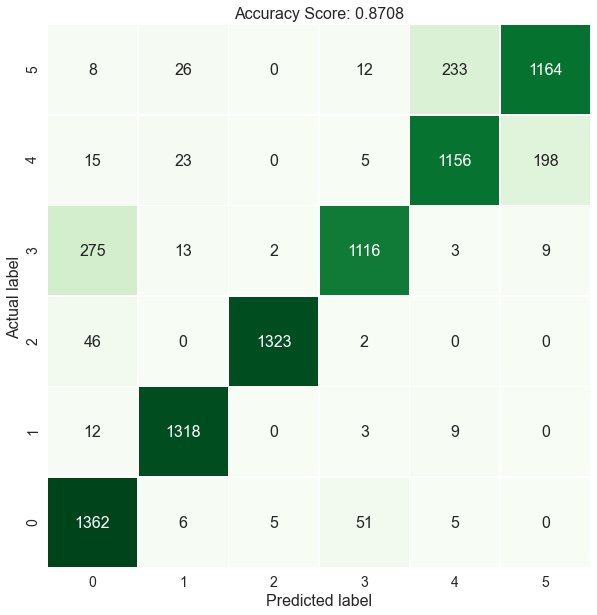

In [185]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, square=True, cbar=False, cmap='Greens')
ax.invert_yaxis()
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.title('Accuracy Score: {:.4f}'.format(inf_acc), fontsize=16)
#ax.xticks(range(6), ["campanian","corylus","dust","grimsvotn","qrobur","qsuber"], rotation=20, fontsize=14)
plt.show()

print('Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix)),np.sum(conf_matrix)))
print('Wrong: {0}/{1}'.format((np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))),np.sum(conf_matrix)))

In [144]:
extractor = tensorflow.keras.Model(inputs=model.inputs,
                        outputs=model.layers[-2].output)

features = extractor([train_images, meta_train_images])
train_label = np.argmax(train_labels, 1)

In [167]:
import umap
reducer = umap.UMAP()
reducer_raw = reducer.fit(features)
umap_transformed = reducer_raw.transform(features)

f_0 = umap_transformed[train_label == 0] 
f_1 = umap_transformed[train_label == 1] 
f_2 = umap_transformed[train_label == 2] 
f_3 = umap_transformed[train_label == 3] 
f_4 = umap_transformed[train_label == 4] 
f_5 = umap_transformed[train_label == 5] 

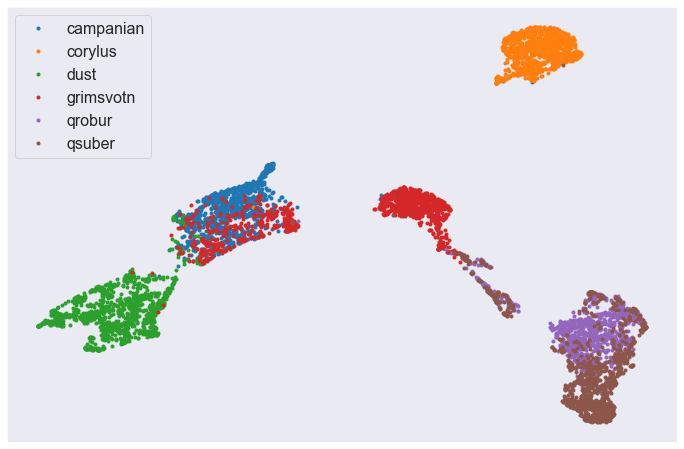

In [168]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(f_0[:,0],f_0[:,1],'.', label = 'campanian')
plt.plot(f_1[:,0],f_1[:,1],'.', label = 'corylus')
plt.plot(f_2[:,0],f_2[:,1],'.', label = 'dust')
plt.plot(f_3[:,0],f_3[:,1],'.', label = 'grimsvotn')
plt.plot(f_4[:,0],f_4[:,1],'.', label = 'qrobur')
plt.plot(f_5[:,0],f_5[:,1],'.', label = 'qsuber')
ax.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=16)

x_axis = ax.get_xaxis()
x_axis.set_visible(False)
y_axis = ax.get_yaxis()
y_axis.set_visible(False)

plt.show()

In [197]:
import matplotlib as mpl
mpl.rc('axes', labelsize=16, titlesize=16)
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['font.size'] = 14

In [190]:
ypred_test = model.predict([test_images, meta_test_images])
ypred_train = model.predict([val_images, meta_val_images])

train_labels = val_labels

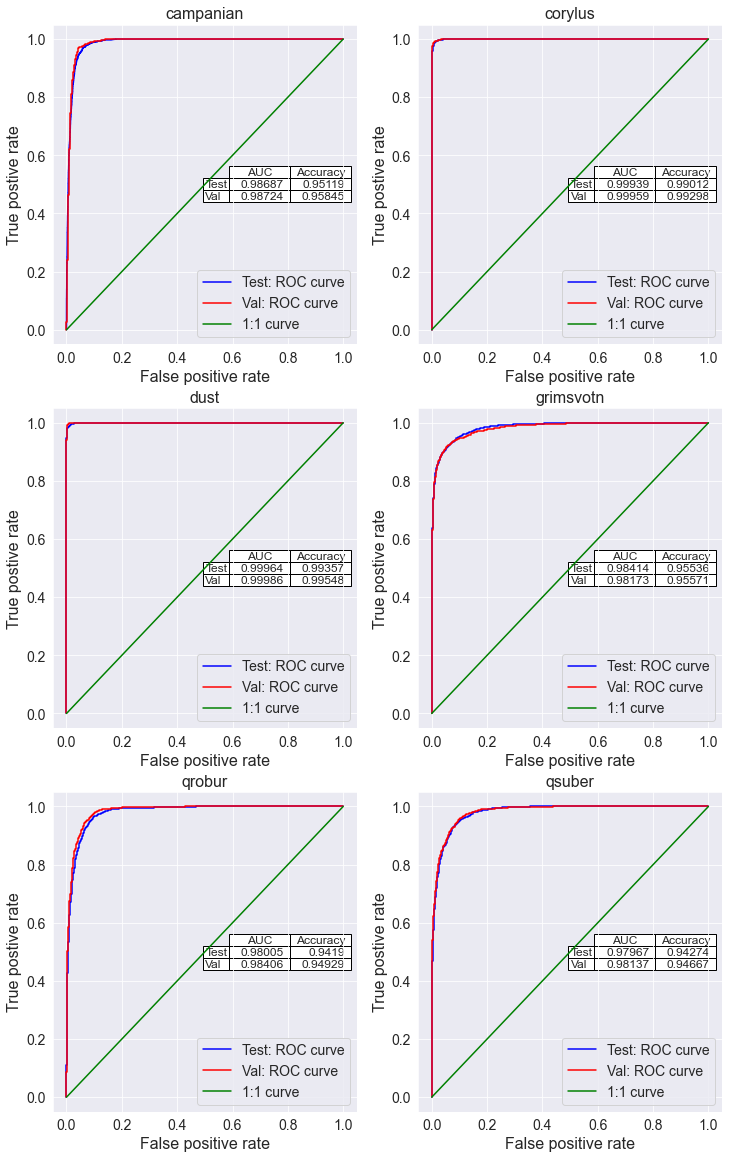

In [198]:
import sklearn
from sklearn.metrics import accuracy_score, auc

# Plotting the ROC curve, to test for overtaining and preformance
title = ["campanian","corylus","dust","grimsvotn","qrobur","qsuber"]
fig1, ax1 = plt.subplots(figsize=(12,20), nrows=3, ncols=2)
ax1 = ax1.flatten()

for i in range(6):
    fpr,tpr, threshold = sklearn.metrics.roc_curve(test_labels[:,i], ypred_test[:,i])
    ax1[i].plot(fpr,tpr,'b', label='Test: ROC curve')

    fpr_train,tpr_train, threshold_train =sklearn.metrics.roc_curve(train_labels[:,i],ypred_train[:,i])
    ax1[i].plot(fpr_train, tpr_train,'r', label='Val: ROC curve')
    ax1[i].plot(np.linspace(0,1,100),np.linspace(0,1,100),'g', label='1:1 curve')
    ax1[i].set(xlabel='False positive rate',ylabel='True postive rate',title=title[i])
    ax1[i].legend()


    # The AUC and accuracy is computed and printed in the figure
    auc_score_train = auc(fpr_train,tpr_train)   
    auc_score_test = auc(fpr,tpr)   

    acc_score_train = accuracy_score(train_labels[:,i],np.where(ypred_train[:,i] > 0.5, 1, 0))
    acc_score_test = accuracy_score(test_labels[:,i],np.where(ypred_test[:,i] > 0.5, 1, 0))

    ax1[i].tick_params(axis='both', which='major', labelsize=14)
    
    
    row_labels=['Test',
            'Val']
    table_vals=[[round(auc_score_test,5),round(acc_score_test,5)],
            [round(auc_score_train,5),round(acc_score_train,5)]]
    col_labels=['AUC','Accuracy']
    the_table = ax1[i].table(cellText=table_vals,
                  colWidths = [0.2]*3,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center right')

In [200]:
test_pred = model.predict([Test_images, meta_Test_images])

In [150]:
test_pred.shape

(63123, 6)

In [201]:
for i in range(6):
    print(f'Type {i}:', sum(np.argmax(test_pred, axis=1) == i))

Type 0: 15876
Type 1: 181
Type 2: 29134
Type 3: 17579
Type 4: 46
Type 5: 307


In [153]:
np.argmax(test_pred, axis=1)

array([0, 2, 2, ..., 2, 2, 0])

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
 <a list of 6 Text major ticklabel objects>)

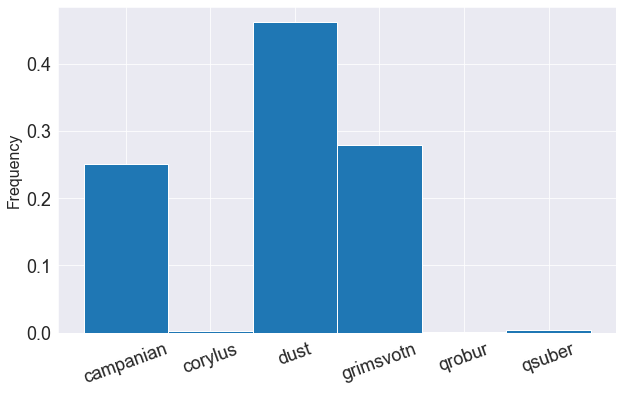

In [204]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(np.argmax(test_pred, axis=1), 6, range=(-0.5, 5.5), density=True);
ax.set( ylabel='Frequency')
plt.xticks(range(6), ["campanian","corylus","dust","grimsvotn","qrobur","qsuber"], rotation=20, fontsize=18)
plt.yticks(fontsize=18)